In [1]:
# 导入库函数
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [2]:
# LPP算法函数

def knn_graph(Data, method, k):
    n = Data.shape[1]  # 修改此处获取样本点的数量
    knn_adjacency_matrix = np.zeros((n, n))  
    distances = np.sqrt(np.sum((Data.T[:, :, None] - Data.T[:, :, None].T) ** 2, axis=1)) # 修改计算欧式距离矩阵的方式
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

def compute_avg_radius(n, distances): 
    radius = np.zeros(n)
    for i in range(n):
        avg_radius = np.mean(distances[:, i])  # 修改计算每个数据点的平均邻域半径的方式
        radius[i] = avg_radius
    return radius

def compute_knn_average_radius(distances, k):
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    avg_knn_distances = np.mean(sorted_distances[:, 1:k+1], axis=1)  # 计算每个数据点的前k个距离的平均值作为半径
    return avg_knn_distances

def compute_neighborhood_matrix(Data, method, k):
    n = Data.shape[1]  # 修改获取样本点的数量的方式
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    adjacency_matrix = np.zeros((n, n))
    radius = compute_knn_average_radius(distances, k)
    for i in range(n):
        neighbors = np.where(distances[:, i] <= radius[i])[0]  # 修改获取epsilon邻域内的样本索引的方式
        adjacency_matrix[i, neighbors] = 1
        adjacency_matrix[neighbors, i] = 1
    return adjacency_matrix, distances

def construct_weight_matrix(Data, method, k, t):
    n = Data.shape[1]  # 修改获取样本点的数量的方式
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    similarity_matrix = np.exp(-distances ** 2 / t)
    i_indices, j_indices = np.where(adjacency_matrix == 1)
    Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]
    #Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix

In [3]:
# MLDA算法函数

# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data, train_labels):
    num_classes = len(np.unique(train_labels))  # 类别数量
    print("类别数量：", num_classes)
    num_samples_per_class = train_data.shape[0] // num_classes  # 每个类别的样本数
    print("每个类别的样本数：", num_samples_per_class)
    num_features = train_data.shape[1]  # 每个样本的特征维度
    print("每个样本的特征维度：", num_features)
    means = np.zeros((num_classes, num_features))  # 存储每个类别的均值矩阵
    for i in range(1, num_classes + 1):  # 遍历每个类别
        temp_indices = np.where(train_labels == i)[0]  # 获取当前类别的训练数据索引
        temp_sum = np.sum(train_data[temp_indices], axis=0)  # 计算当前类别的特征值总和
        means[i-1] = temp_sum / num_samples_per_class  # 计算当前类别的均值
    return means  # 返回每个类别的均值矩阵

# 计算所有类别的整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    overall_mean = np.mean(classes_means, axis=0)  # 计算所有类别的整体均值
    return overall_mean.reshape(-1, 1)  # 返回整体均值矩阵（转置）

# 计算中心类别矩阵
def compute_center_class_matrix(train_data, train_labels, classes_means):
    Z = np.zeros_like(train_data)  # 初始化中心类别矩阵
    
    for i in range(train_data.shape[0]):  # 遍历训练数据
        class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引
        Z[i] = train_data[i] - classes_means[class_index]  # 计算中心类别矩阵
        
    return Z  # 返回中心类别矩阵

# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means, overall_mean):
    n = 5  # 训练集与测试集的比例
    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵
    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵
        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵
    return Sb  # 返回类间散布矩阵

# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    Sw = np.dot(Z.T, Z)  # 计算类内散布矩阵
    return Sw  # 返回类内散布矩阵


In [4]:
def ShowEigenface(eigenfaces, faceshape):
    # 显示前16个特征脸
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
    for i in range(16):
        axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
    plt.show()

In [5]:
def DLPP_LPP(Data, d, method, k, t):
    Data = Data.T
    Weight_matrix = construct_weight_matrix(Data, method, k, t)
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    return Laplacian_matrix, Data


In [6]:
def DLPP_MLDA(train_data, train_labels, d):
    # 计算每个类别的均值矩阵
    classes_means = compute_classes_mean_matrix(train_data, train_labels)
    return classes_means.T

In [7]:
def LPP(Data, d, method, k, t):
    Data = Data.T
    Weight_matrix = construct_weight_matrix(Data, method, k, t)
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    print("LPP拉普拉斯矩阵形状：", Laplacian_matrix.shape)
    objective_value = np.dot(np.dot(Data, Laplacian_matrix), Data.T)  # 计算目标函数
    eigenvalues, eigenvectors = eigs(objective_value, k=d+1)
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors

In [8]:
def MLDA(train_data, train_labels, d):
    # 计算每个类别的均值矩阵
    classes_means = compute_classes_mean_matrix(train_data, train_labels)
    """
    print('classes_means形状：', classes_means.shape)

    # 计算所有类别的整体均值矩阵
    overall_mean = compute_overall_mean_matrix(classes_means)
    print('overall_mean形状：', overall_mean.shape)

    # 计算中心类别矩阵
    Z = compute_center_class_matrix(train_data, train_labels, classes_means)
    print('Z形状：', Z.shape)

    # 计算类间散布矩阵
    Sb = compute_between_class_scatter_matrix(classes_means, overall_mean)
    print('Sb形状：', Sb.shape)

    # 计算类内散布矩阵
    Sw = compute_class_scatter_matrix(Z)
    print('Sw形状：', Sw.shape)
    """
    return classes_means.T

In [9]:
def DLPP(train_data, train_labels, d, method, k, t):
    # Step 1: 使用MLDA进行特征提取
    F = DLPP_MLDA(train_data, train_labels, d)
    print("F形状:", F.shape)
    # Step 2: 使用LPP进行特征提取
    L, X = DLPP_LPP(train_data, d, method, k, t)
    print("拉普拉斯矩阵形状L:", L.shape)
    # Step 3: 计算权重矩阵B
    num_classes = len(np.unique(train_labels))  # 计算训练集中的类别数
    B = np.zeros((num_classes, num_classes))  # 初始化权重矩阵B
    # 遍历每对类别，计算其对应的权重
    for i in range(num_classes):  # 遍历每个类别
        for j in range(num_classes):  # 再次遍历每个类别
            if i != j:  # 如果类别不相同
                fi = F[:,i]  # 获取第i个类别的平均脸
                fj = F[:,j]  # 获取第j个类别的平均脸
                # 计算第i类别和第j类别平均脸之间的欧氏距离，并将其应用于高斯核函数，计算权重
                B[i, j] = np.exp(-np.linalg.norm(fi - fj) ** 2 / t)
    # Step 4: 计算E和H矩阵
    E = np.diag(np.sum(B, axis=1))
    H = E - B
    print("H形状:", H.shape)
    # Step 5: 计算目标函数的分母和分子
    denominator = np.dot(np.dot(F, H), F.T) + 1e-10  # 添加一个微小的非零值，以避免除以零
    #print("分母形状:", denominator.shape)
    numerator = np.dot(np.dot(X, L), X.T)
    #print("分子形状:", numerator.shape)
    # Step 6: 分式
    objective_value = numerator / denominator
    # Step 7: 求解广义特征值问题的特征值和特征向量
    eigenvalues, eigenvectors = eigs(objective_value, k=d+1)
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]  
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors

In [10]:
def PCA(X, n_components):
    # 计算数据矩阵的均值
    mean = np.mean(X, axis=0)
    # 中心化数据矩阵
    X_centered = X - mean
    # 计算数据矩阵的协方差矩阵
    covariance_matrix = np.cov(X_centered, rowvar=False)
    # 计算协方差矩阵的特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    # 对特征向量按特征值从大到小排序
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    # 选取前n_components个特征向量
    principal_components = sorted_eigenvectors[:, :n_components]
    # 返回投影矩阵和均值向量
    return principal_components

In [11]:
# 读取数据集
def read_images(dataset_dir, target_size=(32, 32)):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in os.listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = os.path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = os.path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 缩放图像至目标尺寸
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

# 训练集和测试集划分(按顺序划分)
def train_test_split(data, labels, train_test_split_ratio):
    num_samples = data.shape[0]  # 总样本数
    num_classes = len(np.unique(labels))  # 类别数
    train_samples_per_class = int(train_test_split_ratio * num_samples / num_classes)  # 每个类别的训练样本数
    
    train_indices = []
    test_indices = []
    for i in range(1, num_classes + 1):  # 对每个类别
        class_indices = np.where(labels == i)[0]  # 获取当前类别的索引
        train_indices.extend(class_indices[:train_samples_per_class])  # 将前面部分作为训练集
        test_indices.extend(class_indices[train_samples_per_class:])  # 将后面部分作为测试集
    
    train_data = data[train_indices]
    train_labels = labels[train_indices]
    test_data = data[test_indices]
    test_labels = labels[test_indices]
    
    return train_data, train_labels, test_data, test_labels

In [12]:
"""
from sklearn.datasets import make_swiss_roll

# 设置参数
n_samples = 1000  # 数据点数量
noise = 0.2  # 噪声水平
random_state = 42  # 随机种子，用于重现结果

# 生成带有标签信息的瑞士卷数据集
X, labels = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)
X = X.T
labels = np.array(labels).reshape(-1, 1)
print("X形状:", X.shape)
print("labels形状:", labels.shape)
reduced_data = DLPP(X, labels, 2, 'knn', 10, 1000)


# 打印数据集的形状
print("数据集形状:", X.shape)
print("标签形状:", y.shape)

# 可视化瑞士卷数据集
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Spectral)
ax.set_title('带有标签信息的瑞士卷数据集')
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
plt.title('DLPP降维后的结果（二维）')
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.colorbar(label='类别')
plt.show()
"""

'\nfrom sklearn.datasets import make_swiss_roll\n\n# 设置参数\nn_samples = 1000  # 数据点数量\nnoise = 0.2  # 噪声水平\nrandom_state = 42  # 随机种子，用于重现结果\n\n# 生成带有标签信息的瑞士卷数据集\nX, labels = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)\nX = X.T\nlabels = np.array(labels).reshape(-1, 1)\nprint("X形状:", X.shape)\nprint("labels形状:", labels.shape)\nreduced_data = DLPP(X, labels, 2, \'knn\', 10, 1000)\n\n\n# 打印数据集的形状\nprint("数据集形状:", X.shape)\nprint("标签形状:", y.shape)\n\n# 可视化瑞士卷数据集\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\n\nfig = plt.figure()\nax = fig.add_subplot(111, projection=\'3d\')\nax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Spectral)\nax.set_title(\'带有标签信息的瑞士卷数据集\')\nplt.show()\n\n\nplt.figure(figsize=(8, 6))\nplt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap=\'viridis\')\nplt.title(\'DLPP降维后的结果（二维）\')\nplt.xlabel(\'特征1\')\nplt.ylabel(\'特征2\')\nplt.colorbar(label=\'类别\')\nplt.show()\n'

In [13]:
def test_image(i, train_labels, test_labels, query, weight_matrix):
    query = query.reshape(-1, 1)
    # 计算测试图像权重与数据集中每个人脸权重的欧氏距离
    euclidean_distances = np.linalg.norm(weight_matrix - query, axis=0)
    # 找到最佳匹配的人脸
    best_match_index = np.argmin(euclidean_distances)
    #判断是否匹配正确
    flag = True
    if train_labels[best_match_index] == test_labels[i]:
        flag = True
    else:
        flag = False
    return flag

数据集形状: (10000, 3)
标签形状: (10000,)
类别数量： 3
每个类别的样本数： 3333
每个样本的特征维度： 3
F形状: (3, 3)
拉普拉斯矩阵形状L: (10000, 10000)
H形状: (3, 3)
DLPP降维后的形状: (3, 2)
降维后的形状: (10000, 2)


c:\Softwares\Anaconda\envs\MLH\Lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


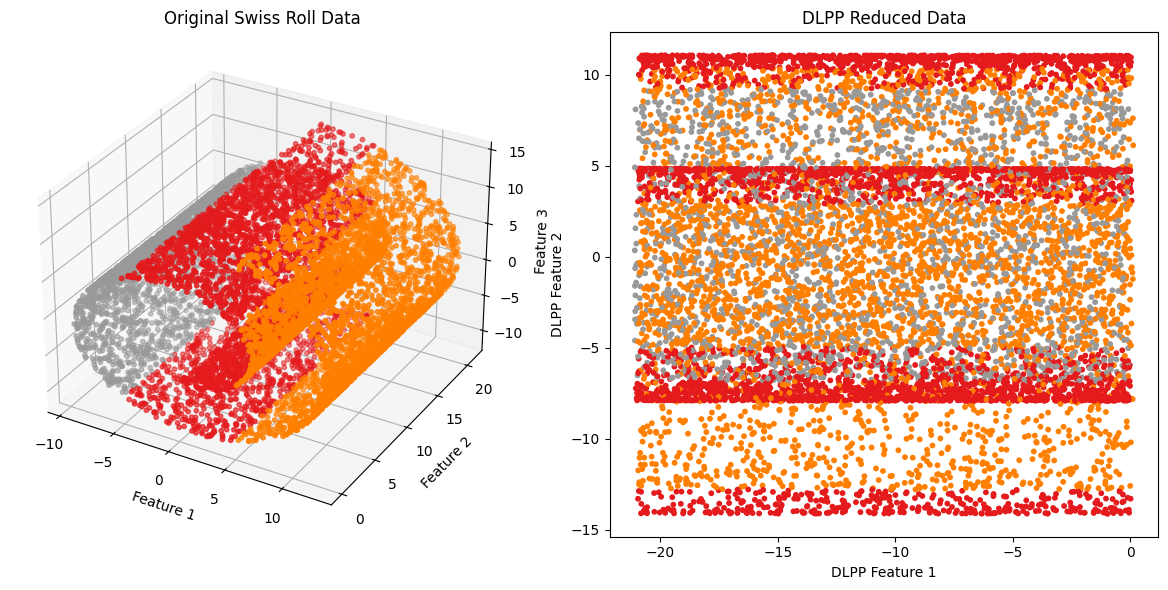

In [14]:
import numpy as np
from sklearn.datasets import make_swiss_roll

# 生成瑞士卷数据集
X, _ = make_swiss_roll(n_samples=10000, noise=0.0)

# 手动为数据集添加标签信息
# 在这个示例中，我们将根据数据点的第一个特征（瑞士卷的横截面）将数据点分为三类：上半部分、中心部分和下半部分
labels = np.zeros(X.shape[0], dtype=int)
labels[X[:, 0] > 5] = 1  # 上半部分
labels[X[:, 0] < -5] = 2  # 下半部分

# 打印数据集形状和标签信息
print("数据集形状:", X.shape)
print("标签形状:", labels.shape)

dlpp_transformation_matrix = DLPP(X, labels, 2, 'knn', 10, 1000)
print("DLPP降维后的形状:", dlpp_transformation_matrix.shape)

swiss_reduced = np.dot(X, dlpp_transformation_matrix)
print("降维后的形状:", swiss_reduced.shape)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建一个新的三维图形
fig = plt.figure(figsize=(12, 6))

# 绘制原始瑞士卷数据集
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Original Swiss Roll Data')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.Set1, s=10)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Feature 3')

# 绘制经 DLPP 降维后的数据集
plt.subplot(122)
plt.title('DLPP Reduced Data')
plt.scatter(swiss_reduced[:, 0], swiss_reduced[:, 1], c=labels, cmap=plt.cm.Set1, s=10)
plt.xlabel('DLPP Feature 1')
plt.ylabel('DLPP Feature 2')

plt.tight_layout()
plt.show()
